## Training Neural Networks for binary classificaton

* Neural Network Hyperparameters consist of: 
    - Number oflayers
    - Number of neurons per layer
    - Layer order
    - Layer activations
    - Batch sizes
    - Learning rates
    - Optimizers
    
* Tips for neural networks hyperparameter tuning
    - Random search is preferred over grid search
    - Use a smaller sample of your dataset (Generally 10000s of total training instances used for neural network models)

### Import Libraries

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.engine.input_layer import Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.models import load_model


from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV



Using TensorFlow backend.


### Define useful Functions

In [2]:
def performance(model, history, X_test, y_test):
    
    # Make predictions on test set
    y_pred=model.predict(X_test)
    y_pred=np.round(y_pred)
    
    # Confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # Accuracy, Precision, Recall, F1 score
    print(classification_report(y_test, y_pred))

    # Training curves (loss)
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.plot(history['val_loss'], linewidth=2, label='Test')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    # Training curves (accuracy)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'])
    plt.show()
    
    # Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.show()

    # ROC curve
    y_pred_prob = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1],'k--')
    plt.plot(fpr, tpr, label='Neural Network')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # AUC score
    print("AUC score: ", roc_auc_score(y_test, y_pred_prob))

### Read in dataset

In [3]:
dataset = pd.read_csv("pima.csv", names=['pregnancies','glucose_conc','bp_mm','skin_thickness_mm','insulin','bmi',
                                         'diabetes_pedigree_func','age','outcome'])
"""
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
"""

'\nfrom sklearn.datasets import fetch_openml\nmnist = fetch_openml(\'mnist_784\', version=1)\n\nX, y = mnist["data"], mnist["target"]\nX_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]\n'

### Data preprocessing

In [ ]:
# Drop rows with 0. 
dataset.drop(dataset[dataset.glucose_conc==0].index, inplace=True)
dataset.drop(dataset[dataset.bp_mm==0].index, inplace=True)
dataset.drop(dataset[dataset.bmi==0].index, inplace=True)
dataset.drop(dataset[dataset.insulin==0].index, inplace=True)
dataset.drop(dataset[dataset.skin_thickness_mm==0].index, inplace=True)
dataset.info()

In [ ]:
# Ratio of positive and negative outcomes
sns.countplot(dataset.outcome)

In [ ]:
# Correlation of predictor features
corr = dataset.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap='RdPu')

In [ ]:
dataset = pd.read_csv("pima.csv", names=['pregnancies','glucose_conc','bp_mm','skin_thickness_mm','insulin','bmi',
                                         'diabetes_pedigree_func','age','outcome'])
dataset.head()

In [4]:
# Replace missing values with median
imp = SimpleImputer(missing_values=0, strategy='median')
data=dataset[['glucose_conc','bp_mm','skin_thickness_mm','insulin','bmi']]
data=imp.fit_transform(data)
dataset[['glucose_conc','bp_mm','skin_thickness_mm','insulin','bmi']]=data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnancies               768 non-null int64
glucose_conc              768 non-null float64
bp_mm                     768 non-null float64
skin_thickness_mm         768 non-null float64
insulin                   768 non-null float64
bmi                       768 non-null float64
diabetes_pedigree_func    768 non-null float64
age                       768 non-null int64
outcome                   768 non-null int64
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [ ]:
dataset.head()

In [5]:
# Set a random seed
np.random.seed(123)

# split into input (X) and output (y) variables
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]

# Split 25% of data into the test set. The rest will be the training set. 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Scale and normalize predictor values.
sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

### Determine best network capacity required for problem

In [6]:
def create_model_capacity(nl=1,nn=12):
    opt = Adam(lr=0.01)
    model = Sequential()
    model.add(Dense(nn+12, input_shape=(8,), activation='relu'))
    model.add(BatchNormalization())
    for i in range(nl):
        model.add(Dense(nn, activation='relu'))
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier
model = KerasClassifier(build_fn = create_model_capacity)

# Define a series of parameters
params = dict(nl=[0,1,2], nn=[12,36,60])

# Define early stop monitor
early_stopping_monitor=EarlyStopping(monitor='accuracy', patience=10)

# Create a random search cv object and fit it to the data
random_search = RandomizedSearchCV(model, param_distributions=params, cv=3) #cv = KFold(3)

start_time = time.time()
random_search_results1 = random_search.fit(X_train, y_train,  epochs=100, batch_size=10, callbacks=[early_stopping_monitor])
print("--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\orpit\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
384/384 [==============================] - 1s 2ms/step - loss: 0.6142 - accuracy: 0.6615
Epoch 2/100
384/384 [==============================] - 0s 239us/step - loss: 0.5186 - accuracy: 0.7083
Epoch 3/100
384/384 [==============================] - 0s 254us/step - loss: 0.4813 - accuracy: 0.7552
Epoch 4/100
384/384 [==============================] - 0s 240us/step - loss: 0.4713 - accuracy: 0.7656
Epoch 5/100
384/384 [==============================] - 0s 239us/step - loss: 0.4735 - accuracy: 0.7786
Epoch 6/100
384/384 [==============================] - 0s 233us/step - loss: 0.4424 - accuracy: 0.7786
Epoch 7/100
384/384 [==============================] - 0s 244us/step - loss: 0.4185 - accuracy: 0.7969
Epoch 8/100
384/384 [==============================] - 0s 251us/step - loss: 0.4754 - accuracy: 0.7708
Epoch 9/100
384/384 [==============================] - 0s 244us/step - loss: 0.4448 - accuracy: 0.7812
Epoch 10/100
384/384 [=====

384/384 [==============================] - 0s 149us/step - loss: 0.4281 - accuracy: 0.7943
Epoch 11/100
384/384 [==============================] - 0s 149us/step - loss: 0.3839 - accuracy: 0.8307
Epoch 12/100
384/384 [==============================] - 0s 147us/step - loss: 0.4152 - accuracy: 0.8125
Epoch 13/100
384/384 [==============================] - 0s 147us/step - loss: 0.3849 - accuracy: 0.8229
Epoch 14/100
384/384 [==============================] - 0s 146us/step - loss: 0.4003 - accuracy: 0.8359
Epoch 15/100
384/384 [==============================] - 0s 152us/step - loss: 0.3946 - accuracy: 0.8229
Epoch 16/100
384/384 [==============================] - 0s 158us/step - loss: 0.4083 - accuracy: 0.8073
Epoch 17/100
384/384 [==============================] - 0s 147us/step - loss: 0.4041 - accuracy: 0.8203
Epoch 18/100
384/384 [==============================] - 0s 147us/step - loss: 0.3948 - accuracy: 0.8229
Epoch 19/100
384/384 [==============================] - 0s 145us/step - loss:

384/384 [==============================] - 0s 155us/step - loss: 0.4571 - accuracy: 0.7865
Epoch 13/100
384/384 [==============================] - 0s 155us/step - loss: 0.3890 - accuracy: 0.8359
Epoch 14/100
384/384 [==============================] - 0s 155us/step - loss: 0.4209 - accuracy: 0.7995
Epoch 15/100
384/384 [==============================] - 0s 156us/step - loss: 0.3866 - accuracy: 0.8229
Epoch 16/100
384/384 [==============================] - 0s 156us/step - loss: 0.4486 - accuracy: 0.7995
Epoch 17/100
384/384 [==============================] - 0s 164us/step - loss: 0.4159 - accuracy: 0.8099
Epoch 18/100
384/384 [==============================] - 0s 158us/step - loss: 0.4156 - accuracy: 0.7969
Epoch 19/100
384/384 [==============================] - 0s 161us/step - loss: 0.3705 - accuracy: 0.8438
Epoch 20/100
384/384 [==============================] - 0s 154us/step - loss: 0.3822 - accuracy: 0.8411
Epoch 21/100
384/384 [==============================] - 0s 164us/step - loss:

384/384 [==============================] - 0s 214us/step - loss: 0.3541 - accuracy: 0.8255
Epoch 42/100
384/384 [==============================] - 0s 212us/step - loss: 0.3256 - accuracy: 0.8542
Epoch 43/100
192/192 [==============================] - 0s 933us/step
Epoch 1/100
384/384 [==============================] - 1s 2ms/step - loss: 0.5977 - accuracy: 0.7188
Epoch 2/100
384/384 [==============================] - 0s 198us/step - loss: 0.5199 - accuracy: 0.7344
Epoch 3/100
384/384 [==============================] - 0s 201us/step - loss: 0.4762 - accuracy: 0.7552
Epoch 4/100
384/384 [==============================] - 0s 194us/step - loss: 0.4622 - accuracy: 0.7812
Epoch 5/100
384/384 [==============================] - 0s 195us/step - loss: 0.4621 - accuracy: 0.7760
Epoch 6/100
384/384 [==============================] - 0s 207us/step - loss: 0.4866 - accuracy: 0.7552
Epoch 7/100
384/384 [==============================] - 0s 198us/step - loss: 0.4680 - accuracy: 0.7943
Epoch 8/100
384/

384/384 [==============================] - 0s 233us/step - loss: 0.3712 - accuracy: 0.8255
Epoch 25/100
384/384 [==============================] - 0s 244us/step - loss: 0.3419 - accuracy: 0.8620
Epoch 26/100
384/384 [==============================] - 0s 265us/step - loss: 0.3437 - accuracy: 0.8385
Epoch 27/100
384/384 [==============================] - 0s 298us/step - loss: 0.3957 - accuracy: 0.8177
Epoch 28/100
384/384 [==============================] - 0s 270us/step - loss: 0.3804 - accuracy: 0.8281
Epoch 29/100
384/384 [==============================] - 0s 270us/step - loss: 0.3521 - accuracy: 0.8411
Epoch 30/100
384/384 [==============================] - 0s 267us/step - loss: 0.3659 - accuracy: 0.8255
Epoch 31/100
384/384 [==============================] - 0s 265us/step - loss: 0.3358 - accuracy: 0.8281
Epoch 32/100
384/384 [==============================] - 0s 264us/step - loss: 0.4410 - accuracy: 0.7943
Epoch 33/100
384/384 [==============================] - 0s 248us/step - loss:

384/384 [==============================] - 0s 257us/step - loss: 0.3915 - accuracy: 0.8203
Epoch 15/100
384/384 [==============================] - 0s 257us/step - loss: 0.4199 - accuracy: 0.8177
Epoch 16/100
384/384 [==============================] - 0s 309us/step - loss: 0.4079 - accuracy: 0.8177
Epoch 17/100
384/384 [==============================] - 0s 275us/step - loss: 0.3737 - accuracy: 0.8385
Epoch 18/100
384/384 [==============================] - 0s 270us/step - loss: 0.4021 - accuracy: 0.8151
Epoch 19/100
384/384 [==============================] - 0s 473us/step - loss: 0.3895 - accuracy: 0.8333
Epoch 20/100
384/384 [==============================] - 0s 413us/step - loss: 0.4114 - accuracy: 0.8281
Epoch 21/100
384/384 [==============================] - 0s 267us/step - loss: 0.3874 - accuracy: 0.8281
Epoch 22/100
384/384 [==============================] - 0s 306us/step - loss: 0.3714 - accuracy: 0.8281
Epoch 23/100
384/384 [==============================] - 0s 293us/step - loss:

384/384 [==============================] - 0s 301us/step - loss: 0.4729 - accuracy: 0.7865
Epoch 8/100
384/384 [==============================] - 0s 310us/step - loss: 0.4591 - accuracy: 0.7708
Epoch 9/100
384/384 [==============================] - 0s 313us/step - loss: 0.4520 - accuracy: 0.7891
Epoch 10/100
384/384 [==============================] - 0s 354us/step - loss: 0.4397 - accuracy: 0.7995
Epoch 11/100
384/384 [==============================] - 0s 319us/step - loss: 0.4536 - accuracy: 0.7812
Epoch 12/100
384/384 [==============================] - 0s 364us/step - loss: 0.4649 - accuracy: 0.8021
Epoch 13/100
384/384 [==============================] - 0s 336us/step - loss: 0.4529 - accuracy: 0.7734
Epoch 14/100
384/384 [==============================] - 0s 301us/step - loss: 0.4219 - accuracy: 0.8229
Epoch 15/100
384/384 [==============================] - 0s 335us/step - loss: 0.3909 - accuracy: 0.8177
Epoch 16/100
384/384 [==============================] - 0s 347us/step - loss: 0

384/384 [==============================] - 0s 351us/step - loss: 0.4361 - accuracy: 0.7969
Epoch 19/100
384/384 [==============================] - 0s 350us/step - loss: 0.4484 - accuracy: 0.7865
Epoch 20/100
384/384 [==============================] - 0s 371us/step - loss: 0.4271 - accuracy: 0.7865
Epoch 21/100
384/384 [==============================] - 0s 359us/step - loss: 0.4118 - accuracy: 0.7969
Epoch 22/100
384/384 [==============================] - 0s 359us/step - loss: 0.4038 - accuracy: 0.8099
Epoch 23/100
384/384 [==============================] - 0s 350us/step - loss: 0.4431 - accuracy: 0.7891
Epoch 24/100
384/384 [==============================] - 0s 367us/step - loss: 0.4163 - accuracy: 0.7734
Epoch 25/100
384/384 [==============================] - 0s 356us/step - loss: 0.3784 - accuracy: 0.8177
Epoch 26/100
384/384 [==============================] - 0s 358us/step - loss: 0.4209 - accuracy: 0.7969
Epoch 27/100
384/384 [==============================] - 0s 371us/step - loss:

384/384 [==============================] - 0s 480us/step - loss: 0.4650 - accuracy: 0.7656
Epoch 8/100
384/384 [==============================] - 0s 397us/step - loss: 0.4387 - accuracy: 0.8099
Epoch 9/100
384/384 [==============================] - 0s 469us/step - loss: 0.4359 - accuracy: 0.8177
Epoch 10/100
384/384 [==============================] - 0s 406us/step - loss: 0.4344 - accuracy: 0.8073
Epoch 11/100
384/384 [==============================] - 0s 425us/step - loss: 0.4408 - accuracy: 0.7891
Epoch 12/100
384/384 [==============================] - 0s 448us/step - loss: 0.4143 - accuracy: 0.8255
Epoch 13/100
384/384 [==============================] - 0s 380us/step - loss: 0.4079 - accuracy: 0.8203
Epoch 14/100
384/384 [==============================] - 0s 382us/step - loss: 0.4282 - accuracy: 0.7943
Epoch 15/100
384/384 [==============================] - 0s 459us/step - loss: 0.4074 - accuracy: 0.7891
Epoch 16/100
384/384 [==============================] - 0s 380us/step - loss: 0

In [7]:
# Print results
print("Best score: {:.4f} using {}".format(random_search_results1.best_score_,random_search_results1.best_params_))

Best score: 0.7413 using {'nn': 60, 'nl': 0}


### Determine best hyperparameters

In [8]:
def create_model_parameters(learning_rate=0.001, activation='relu'):
    
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
    
    # Create your binary classification model  
    model = Sequential()
    model.add(Dense(72, input_dim=8, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(60, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier
model = KerasClassifier(build_fn = create_model_parameters)

# Define a series of parameters
params = dict(batch_size=[10], activation=['relu','tanh', 'elu', 'selu'], learning_rate=[0.00001,0.01])

# Define early stop monitor
early_stopping_monitor=EarlyStopping(monitor='accuracy', patience=10)

# Create a random search cv object and fit it to the data
random_search = RandomizedSearchCV(model, param_distributions=params, cv=3)

start_time = time.time()
random_search_results2 = random_search.fit(X_train, y_train, epochs=100, callbacks=[early_stopping_monitor])
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\orpit\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Epoch 1/100
384/384 [==============================] - 1s 4ms/step - loss: 0.7033 - accuracy: 0.5833
Epoch 2/100
384/384 [==============================] - 0s 425us/step - loss: 0.5437 - accuracy: 0.7266
Epoch 3/100
384/384 [==============================] - 0s 416us/step - loss: 0.4797 - accuracy: 0.7474
Epoch 4/100
384/384 [==============================] - 0s 413us/step - loss: 0.5050 - accuracy: 0.7344
Epoch 5/100
384/384 [==============================] - 0s 409us/step - loss: 0.4921 - accuracy: 0.7526
Epoch 6/100
384/384 [==============================] - 0s 416us/step - loss: 0.4363 - accuracy: 0.7995
Epoch 7/100
384/384 [==============================] - 0s 434us/step - loss: 0.4293 - accuracy: 0.7943
Epoch 8/100
384/384 [==============================] - 0s 443us/step - loss: 0.4208 - accuracy: 0.7943
Epoch 9/100
384/384 [==============================] - 0s 408us/step - loss: 0.4020 - accuracy: 0.8177
Epoch 10/100
384/384 [==============================] - 0s 413us/step - los

384/384 [==============================] - 0s 859us/step - loss: 0.4620 - accuracy: 0.7917
Epoch 7/100
384/384 [==============================] - 0s 840us/step - loss: 0.4647 - accuracy: 0.7969
Epoch 8/100
384/384 [==============================] - 0s 904us/step - loss: 0.4418 - accuracy: 0.8021
Epoch 9/100
384/384 [==============================] - 0s 909us/step - loss: 0.4233 - accuracy: 0.79430s - loss: 0.4472 - accuracy
Epoch 10/100
384/384 [==============================] - 0s 1ms/step - loss: 0.4416 - accuracy: 0.7760
Epoch 11/100
384/384 [==============================] - 0s 766us/step - loss: 0.3978 - accuracy: 0.8125
Epoch 12/100
384/384 [==============================] - 0s 603us/step - loss: 0.4002 - accuracy: 0.8021
Epoch 13/100
384/384 [==============================] - 0s 654us/step - loss: 0.3934 - accuracy: 0.8099
Epoch 14/100
384/384 [==============================] - 0s 673us/step - loss: 0.4142 - accuracy: 0.7786
Epoch 15/100
384/384 [==============================] 

384/384 [==============================] - 0s 585us/step - loss: 0.3775 - accuracy: 0.8438
Epoch 56/100
384/384 [==============================] - 0s 446us/step - loss: 0.3907 - accuracy: 0.8073
Epoch 57/100
384/384 [==============================] - 0s 442us/step - loss: 0.3523 - accuracy: 0.8307
Epoch 58/100
384/384 [==============================] - 0s 438us/step - loss: 0.4215 - accuracy: 0.8255
Epoch 59/100
384/384 [==============================] - 0s 452us/step - loss: 0.3971 - accuracy: 0.8333
Epoch 60/100
384/384 [==============================] - 0s 457us/step - loss: 0.3795 - accuracy: 0.8203
Epoch 61/100
384/384 [==============================] - 0s 475us/step - loss: 0.3822 - accuracy: 0.8359
Epoch 62/100
192/192 [==============================] - 1s 5ms/step
Epoch 1/100
384/384 [==============================] - 2s 5ms/step - loss: 0.6157 - accuracy: 0.6979
Epoch 2/100
384/384 [==============================] - 0s 448us/step - loss: 0.5289 - accuracy: 0.7188
Epoch 3/100
3

384/384 [==============================] - 0s 599us/step - loss: 0.4451 - accuracy: 0.7943
Epoch 20/100
384/384 [==============================] - 0s 576us/step - loss: 0.4890 - accuracy: 0.7526
Epoch 21/100
384/384 [==============================] - 0s 584us/step - loss: 0.4623 - accuracy: 0.7786
Epoch 22/100
384/384 [==============================] - 0s 504us/step - loss: 0.4451 - accuracy: 0.7865
Epoch 23/100
384/384 [==============================] - 0s 660us/step - loss: 0.4383 - accuracy: 0.7891
Epoch 24/100
192/192 [==============================] - 1s 6ms/step
Epoch 1/100
384/384 [==============================] - 2s 5ms/step - loss: 0.6108 - accuracy: 0.6823
Epoch 2/100
384/384 [==============================] - 0s 518us/step - loss: 0.5064 - accuracy: 0.7500
Epoch 3/100
384/384 [==============================] - 0s 513us/step - loss: 0.5045 - accuracy: 0.7396
Epoch 4/100
384/384 [==============================] - 0s 531us/step - loss: 0.5031 - accuracy: 0.7474
Epoch 5/100
384

384/384 [==============================] - 0s 862us/step - loss: 0.4798 - accuracy: 0.7734
Epoch 18/100
384/384 [==============================] - 0s 913us/step - loss: 0.4211 - accuracy: 0.7891
Epoch 19/100
384/384 [==============================] - 0s 920us/step - loss: 0.4628 - accuracy: 0.7760
Epoch 20/100
384/384 [==============================] - 0s 703us/step - loss: 0.4534 - accuracy: 0.7812
Epoch 21/100
384/384 [==============================] - 0s 597us/step - loss: 0.4417 - accuracy: 0.7734
Epoch 22/100
384/384 [==============================] - 0s 586us/step - loss: 0.4556 - accuracy: 0.7708
Epoch 23/100
384/384 [==============================] - 0s 634us/step - loss: 0.4569 - accuracy: 0.7630
Epoch 24/100
384/384 [==============================] - 0s 563us/step - loss: 0.4405 - accuracy: 0.7865
Epoch 25/100
384/384 [==============================] - 0s 621us/step - loss: 0.4624 - accuracy: 0.7760
Epoch 26/100
384/384 [==============================] - 0s 557us/step - loss:

384/384 [==============================] - 0s 669us/step - loss: 0.4722 - accuracy: 0.7656
Epoch 7/100
384/384 [==============================] - 0s 686us/step - loss: 0.4759 - accuracy: 0.7891
Epoch 8/100
384/384 [==============================] - 0s 614us/step - loss: 0.4463 - accuracy: 0.8047
Epoch 9/100
384/384 [==============================] - 0s 636us/step - loss: 0.4696 - accuracy: 0.7943
Epoch 10/100
384/384 [==============================] - 0s 621us/step - loss: 0.4467 - accuracy: 0.7656
Epoch 11/100
384/384 [==============================] - 0s 630us/step - loss: 0.4580 - accuracy: 0.7839
Epoch 12/100
384/384 [==============================] - 0s 703us/step - loss: 0.4652 - accuracy: 0.7786
Epoch 13/100
384/384 [==============================] - 0s 829us/step - loss: 0.4563 - accuracy: 0.7865
Epoch 14/100
384/384 [==============================] - 0s 626us/step - loss: 0.4646 - accuracy: 0.7891
Epoch 15/100
384/384 [==============================] - 0s 656us/step - loss: 0.

In [9]:
# Print results
print("Best score: {:.4f} using {}".format(random_search_results2.best_score_,random_search_results2.best_params_))

Best score: 0.7622 using {'learning_rate': 1e-05, 'batch_size': 10, 'activation': 'selu'}


Train on 403 samples, validate on 173 samples
Epoch 1/100
403/403 [==============================] - 4s 10ms/step - loss: 0.8127 - accuracy: 0.5459 - val_loss: 0.6554 - val_accuracy: 0.6358
Epoch 2/100
403/403 [==============================] - 0s 862us/step - loss: 0.7680 - accuracy: 0.5906 - val_loss: 0.6505 - val_accuracy: 0.6474
Epoch 3/100
403/403 [==============================] - 0s 860us/step - loss: 0.7589 - accuracy: 0.6055 - val_loss: 0.6479 - val_accuracy: 0.6647
Epoch 4/100
403/403 [==============================] - 0s 831us/step - loss: 0.7365 - accuracy: 0.6055 - val_loss: 0.6462 - val_accuracy: 0.6763
Epoch 5/100
403/403 [==============================] - 0s 853us/step - loss: 0.7390 - accuracy: 0.6055 - val_loss: 0.6441 - val_accuracy: 0.6763
Epoch 6/100
403/403 [==============================] - 0s 832us/step - loss: 0.7041 - accuracy: 0.6228 - val_loss: 0.6391 - val_accuracy: 0.6936
Epoch 7/100
403/403 [==============================] - 0s 846us/step - loss: 0.7059 -

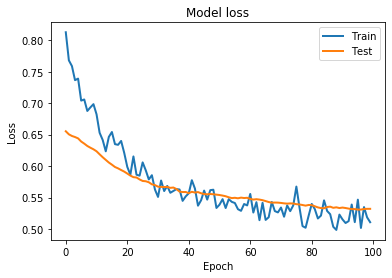

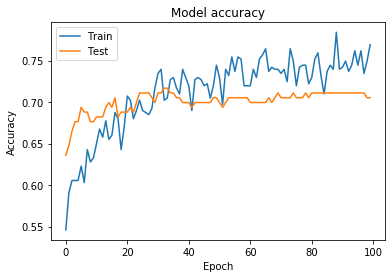

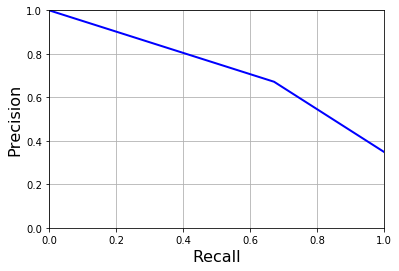

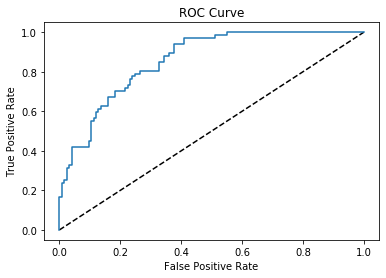

AUC score:  0.8581492537313433
Train on 403 samples, validate on 173 samples
Epoch 1/100
403/403 [==============================] - 5s 12ms/step - loss: 0.7562 - accuracy: 0.4764 - val_loss: 0.7031 - val_accuracy: 0.5491
Epoch 2/100
403/403 [==============================] - 0s 841us/step - loss: 0.6299 - accuracy: 0.6700 - val_loss: 0.6324 - val_accuracy: 0.6647
Epoch 3/100
403/403 [==============================] - 0s 932us/step - loss: 0.5838 - accuracy: 0.6973 - val_loss: 0.5882 - val_accuracy: 0.7110
Epoch 4/100
403/403 [==============================] - 0s 832us/step - loss: 0.5463 - accuracy: 0.7246 - val_loss: 0.5651 - val_accuracy: 0.7052
Epoch 5/100
403/403 [==============================] - 0s 868us/step - loss: 0.5307 - accuracy: 0.7270 - val_loss: 0.5528 - val_accuracy: 0.7052
Epoch 6/100
403/403 [==============================] - 0s 928us/step - loss: 0.5248 - accuracy: 0.7419 - val_loss: 0.5435 - val_accuracy: 0.7052
Epoch 7/100
403/403 [==============================] -

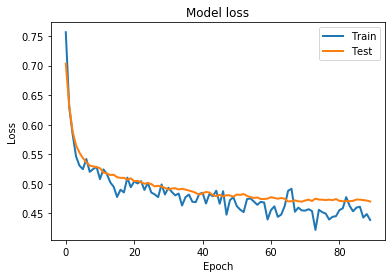

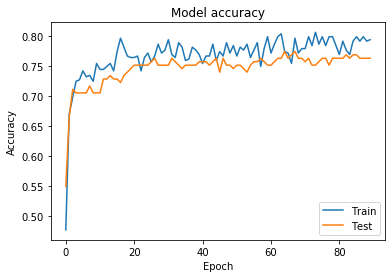

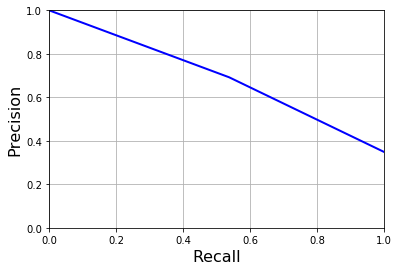

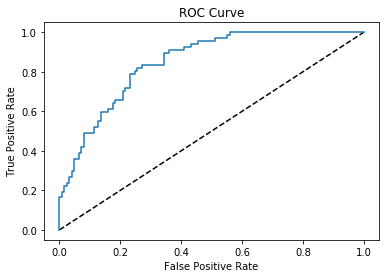

AUC score:  0.849313432835821
Train on 403 samples, validate on 173 samples
Epoch 1/100
403/403 [==============================] - 4s 11ms/step - loss: 0.5531 - accuracy: 0.7395 - val_loss: 0.5321 - val_accuracy: 0.7457
Epoch 2/100
403/403 [==============================] - 0s 849us/step - loss: 0.5334 - accuracy: 0.7345 - val_loss: 0.5012 - val_accuracy: 0.7688
Epoch 3/100
403/403 [==============================] - 0s 916us/step - loss: 0.4923 - accuracy: 0.7643 - val_loss: 0.4924 - val_accuracy: 0.7283
Epoch 4/100
403/403 [==============================] - 0s 850us/step - loss: 0.4765 - accuracy: 0.7792 - val_loss: 0.4817 - val_accuracy: 0.7457
Epoch 5/100
403/403 [==============================] - 0s 876us/step - loss: 0.4882 - accuracy: 0.7816 - val_loss: 0.4929 - val_accuracy: 0.7283
Epoch 6/100
403/403 [==============================] - 0s 906us/step - loss: 0.4899 - accuracy: 0.7891 - val_loss: 0.4732 - val_accuracy: 0.7514
Epoch 7/100
403/403 [==============================] - 

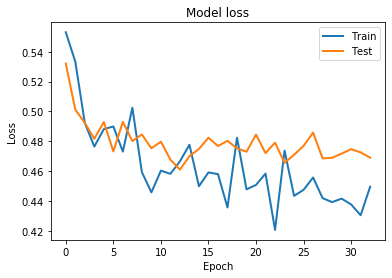

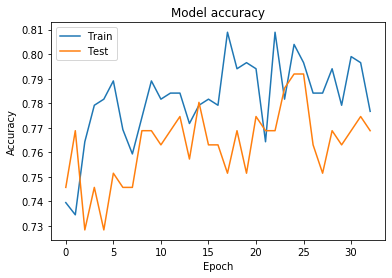

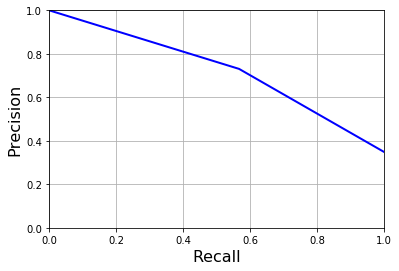

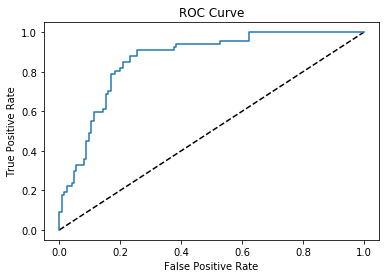

AUC score:  0.8628059701492538


In [18]:
# Trying out a few more learning rates for Adam optimizer. 
# Also use a validation split of 0.3 and change early stop monitor from 'accuracy' to 'val_loss'

def get_new_model():
    model = Sequential()
    model.add(Dense(72, input_dim=8, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dense(60, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    return(model)

# Define early stop monitor
early_stopping_monitor=EarlyStopping(monitor='val_loss', patience=20)

lr_to_test=[0.00001,0.0001, 0.001]
# 0.001 is default Adam learning rate
for lr in lr_to_test:
    model=get_new_model()
    opt=Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history=model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.3, callbacks=[early_stopping_monitor]).history
    performance(model, history, X_test, y_test)
    
# AUC score is similar for all learning rates (84-86%). 
# But the highest learning rate is unstable (as observed from learning curves.)
# So the middle learning rate (0.0001) is the best for use. 

### Best model performance

In [23]:
# Study model without early stop callback- to ensure that we are not stuck in local minima. 
# Use the 'save best model' callback instead. 

# create model.
model = Sequential()
opt = Adam(lr=0.0001)
model.add(Dense(72, input_dim=8, activation='selu'))
model.add(BatchNormalization())
model.add(Dense(60, activation='selu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Instantiate a model checkpoint callback
model_save = ModelCheckpoint('best_model.hdf5',save_best_only=True)

# Fit the model
history1=model.fit(X_train, y_train, epochs=200, batch_size=10, validation_split=0.3, callbacks = [model_save]).history

Train on 403 samples, validate on 173 samples
Epoch 1/200
403/403 [==============================] - 7s 17ms/step - loss: 0.6225 - accuracy: 0.6600 - val_loss: 0.6200 - val_accuracy: 0.6994
Epoch 2/200
403/403 [==============================] - 1s 1ms/step - loss: 0.5937 - accuracy: 0.6998 - val_loss: 0.5879 - val_accuracy: 0.6879
Epoch 3/200
403/403 [==============================] - 1s 1ms/step - loss: 0.5617 - accuracy: 0.7022 - val_loss: 0.5675 - val_accuracy: 0.6994
Epoch 4/200
403/403 [==============================] - 1s 1ms/step - loss: 0.5492 - accuracy: 0.7395 - val_loss: 0.5556 - val_accuracy: 0.6994
Epoch 5/200
403/403 [==============================] - 1s 1ms/step - loss: 0.5476 - accuracy: 0.7395 - val_loss: 0.5467 - val_accuracy: 0.6879
Epoch 6/200
403/403 [==============================] - 1s 1ms/step - loss: 0.5295 - accuracy: 0.7345 - val_loss: 0.5353 - val_accuracy: 0.6936
Epoch 7/200
403/403 [==============================] - 1s 1ms/step - loss: 0.5189 - accuracy: 0

Epoch 113/200
403/403 [==============================] - 0s 924us/step - loss: 0.4644 - accuracy: 0.8015 - val_loss: 0.4745 - val_accuracy: 0.7630
Epoch 114/200
403/403 [==============================] - 0s 911us/step - loss: 0.4567 - accuracy: 0.7916 - val_loss: 0.4723 - val_accuracy: 0.7572
Epoch 115/200
403/403 [==============================] - 0s 918us/step - loss: 0.4541 - accuracy: 0.7767 - val_loss: 0.4707 - val_accuracy: 0.7457
Epoch 116/200
403/403 [==============================] - 0s 885us/step - loss: 0.4196 - accuracy: 0.8114 - val_loss: 0.4748 - val_accuracy: 0.7572
Epoch 117/200
403/403 [==============================] - 0s 1ms/step - loss: 0.4611 - accuracy: 0.7866 - val_loss: 0.4732 - val_accuracy: 0.7514
Epoch 118/200
403/403 [==============================] - 0s 1ms/step - loss: 0.4385 - accuracy: 0.8114 - val_loss: 0.4756 - val_accuracy: 0.7630
Epoch 119/200
403/403 [==============================] - 0s 1ms/step - loss: 0.4519 - accuracy: 0.7792 - val_loss: 0.4746 

Epoch 169/200
403/403 [==============================] - 1s 2ms/step - loss: 0.4190 - accuracy: 0.8015 - val_loss: 0.4771 - val_accuracy: 0.7514
Epoch 170/200
403/403 [==============================] - 1s 2ms/step - loss: 0.4238 - accuracy: 0.8015 - val_loss: 0.4722 - val_accuracy: 0.7514
Epoch 171/200
403/403 [==============================] - 0s 918us/step - loss: 0.4412 - accuracy: 0.7866 - val_loss: 0.4722 - val_accuracy: 0.7572
Epoch 172/200
403/403 [==============================] - 0s 1ms/step - loss: 0.4357 - accuracy: 0.7940 - val_loss: 0.4748 - val_accuracy: 0.7514
Epoch 173/200
403/403 [==============================] - 0s 1ms/step - loss: 0.4406 - accuracy: 0.8089 - val_loss: 0.4730 - val_accuracy: 0.7572
Epoch 174/200
403/403 [==============================] - 1s 2ms/step - loss: 0.4356 - accuracy: 0.7916 - val_loss: 0.4708 - val_accuracy: 0.7630
Epoch 175/200
403/403 [==============================] - 0s 1ms/step - loss: 0.4657 - accuracy: 0.7866 - val_loss: 0.4715 - val_

[[110  15]
 [ 34  33]]
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       125
           1       0.69      0.49      0.57        67

    accuracy                           0.74       192
   macro avg       0.73      0.69      0.70       192
weighted avg       0.74      0.74      0.73       192



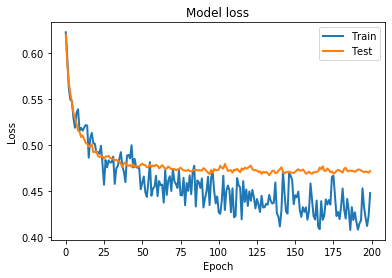

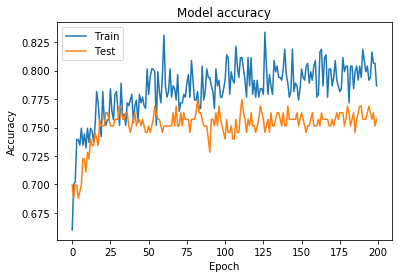

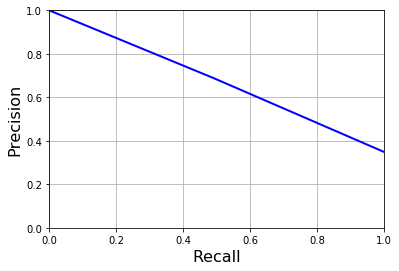

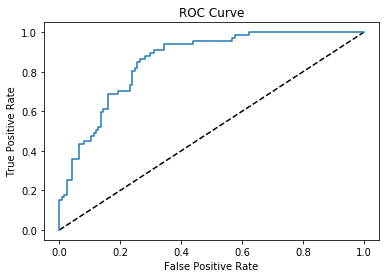

AUC score:  0.8555223880597014


In [24]:
performance(model, history1, X_test, y_test)

### Best model performance

In [28]:
# Load model for reuse
best_model=load_model('best_model.hdf5')

# model summary
best_model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_189 (Dense)            (None, 72)                648       
_________________________________________________________________
batch_normalization_126 (Bat (None, 72)                288       
_________________________________________________________________
dense_190 (Dense)            (None, 60)                4380      
_________________________________________________________________
batch_normalization_127 (Bat (None, 60)                240       
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 61        
Total params: 5,617
Trainable params: 5,353
Non-trainable params: 264
_________________________________________________________________


[[113  12]
 [ 32  35]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       125
           1       0.74      0.52      0.61        67

    accuracy                           0.77       192
   macro avg       0.76      0.71      0.73       192
weighted avg       0.77      0.77      0.76       192



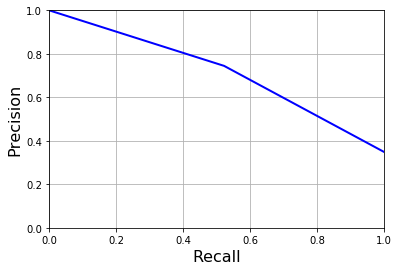

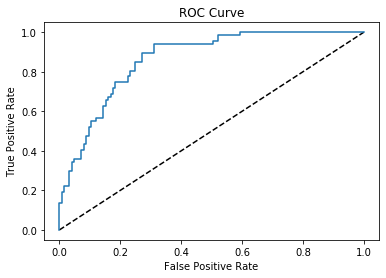

AUC score:  0.8638805970149254


In [33]:
# Make predictions on test set
y_pred=best_model.predict(X_test)
y_pred=np.round(y_pred)
    
# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# Accuracy, Precision, Recall, F1 score
print(classification_report(y_test, y_pred))

# Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
y_pred_prob = best_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1],'k--')
plt.plot(fpr, tpr, label='Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# AUC score
print("AUC score: ", roc_auc_score(y_test, y_pred_prob))

### Pipeline